# Using MORF for Synapse Classification
# Import necessary packages

In [1]:
import skimage
import intern
import matplotlib.pyplot as plt
import numpy as np
from intern.remote.boss import BossRemote
import cv2
import random
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from rerf.rerfClassifier import rerfClassifier

# Pulling a Electron Microscopy Volume from BossDB

The dataset is a volume of mouse visual cortex imaged using electron microscopy. Both the ground truth dense synapse labels are open source and located in a cloud-based database called BossDB.

In [2]:
token = 'public'
raw_channel = 'em'
anno_channel = 'synapse'
collection = 'Kasthuri'
experiment = 'ac4'
resolution = 0
xstart = 1
xstop = 1024
ystart = 1
ystop = 1024
zstart = 1
zstop = 100

In [3]:
boss = BossRemote({"protocol" : "https","host" : "api.bossdb.io","token" : token})
volume_raw = boss.get_cutout(boss.get_channel(raw_channel, collection, experiment),resolution,
[xstart, xstop], [ystart, ystop], [zstart, zstop])
volume_anno = boss.get_cutout(boss.get_channel(anno_channel, collection, experiment),resolution,
[xstart, xstop], [ystart, ystop], [zstart, zstop])

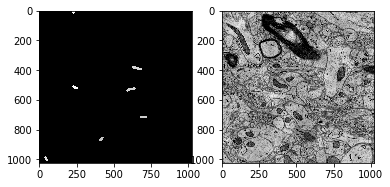

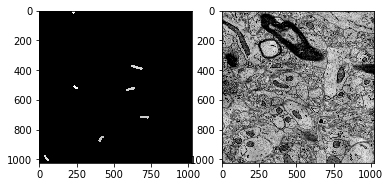

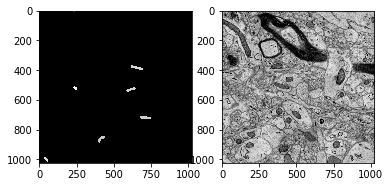

In [4]:
for i in range(3):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(volume_anno[i, :, :], cmap = 'gray')
    ax[1].imshow(volume_raw[i, :, :], cmap = 'gray')

In [5]:
print("Number of synapses: " + str(len(np.unique(volume_anno)) - 1))

Number of synapses: 127


## Define Necessary Functions for Preprocessing Data

In [6]:
def get_center(labeled_image):
    # get center of each synapse
    # param labeled_image: densly labeled image (0 for nonsynapse, 1 - num_synapses for synapse)
    # returns positions: dictionary containing centers of all synapses in image (y,x)
    positions = {}
    labels, areas = np.unique(labeled_image, return_counts = True)
    for label, area in zip(labels, areas):
        if label != 0:
            i, j = np.where(labeled_image == label)
            meanx = 0
            meany = 0
            for num in range(len(i)):
                (row, col) = (i[num], j[num])
                meanx += col/area
                meany += row/area
            positions[label] = {}
            positions[label] = meany, meanx         
   
    return positions

def get_highest_area(labeled_volume):
    # determine largest area of a synapse in a volume
    # not used (originally planned to use this to form bounding box)
    labels, areas = np.unique(labeled_volume, return_counts = True)
    return areas[np.argmax(areas)]

def get_bounding_box(positions, most_area, label, anno_image):
    # obtain bounding box of size 2 * most_area by 2 * most_area around a synapse
    # param positions: position dictionary
    # param most_area: half of desired bounding box width and height
    # param label: synapse label of interest
    # param anno_image : densly labeled image (0 for nonsynapse, 1 - num_synapses for synapse)
    # return : y1, y2, x1, x2 (starting and ending coords in x and y for bounding square)
    y_start = positions[label][0] - most_area
    y_end = positions[label][0] + most_area
    if y_start < 0:
        y_start = 0
        y_end = most_area * 2
    elif y_end > anno_image.shape[0] - 1:
        y_start = anno_image.shape[0] - 1 - most_area * 2
        y_end = anno_image.shape[0] - 1
        
    x_start = positions[label][1] - most_area       
    x_end = positions[label][1] + most_area
    if x_start < 0:
        x_start = 0
        x_end = most_area * 2
    elif x_end > anno_image.shape[1] - 1:
        x_start = anno_image.shape[1] - 1 - most_area * 2
        x_end = anno_image.shape[1] - 1
    assert(int(round(y_end)) - int(round(y_start)) == int(round(x_end)) - int(round(x_start)))
    return int(round(y_start)), int(round(y_end)), int(round(x_start)), int(round(x_end))

def get_synapse_images(anno_volume, raw_volume):
    # save annotation and raw data image for each synapse in each slice of volume
    # param anno_volume: volume with dense synapse annotations (3D)
    # param raw_volume : volume of raw EM data (3D)
    slices = anno_volume.shape[0]
    count = 1
    most_area = get_highest_area(anno_volume) # not used
    for z in range(slices):
        anno_image = anno_volume[z]
        labels = np.unique(anno_image)
        positions = get_center(anno_image)
        for label in labels:
            if label == 0:
                continue
            y1, y2, x1, x2 = get_bounding_box(positions, 50 , label, anno_image)#int(most_area / 100)
            if raw_volume[z, y1:y2, x1:x2].shape != (100,100):
                print("hi!")
            if not cv2.imwrite('raw_data/raw_' + str(count) + '.png', raw_volume[z, y1:y2, x1:x2]):
                raise Exception("Could not write image")
            if not cv2.imwrite('anno_data/anno_' + str(count) + '.png', anno_volume[z, y1:y2, x1:x2]):
                raise Exception("Could not write image")
            count += 1
            
            
def get_nonsynapse_images(anno_volume, raw_volume, num_samples):
    # save desired number of nonsynapse images (randomly generated)
    # param anno_volume: volume with dense synapse annotations (3D)
    # param raw_volume : volume of raw EM data (3D)
    # param num_samples: desired number of nonsynapse samples
    y_len = anno_volume.shape[1] - 101
    x_len = anno_volume.shape[2] - 101
    i = 0
    while i < num_samples:
        x1 = random.randint(0,x_len)
        y1 = random.randint(0,y_len)
        z = random.randint(1,98)
        x2 = x1 + 100
        y2 = y1 + 100
        if np.max(anno_volume[z, y1:y2, x1:x2]) > 0:
            continue
        else:
            if not cv2.imwrite('raw_data_0/raw_' + str(i) + '.png', raw_volume[z, y1:y2, x1:x2]):
                raise Exception("Could not write image")
            if not cv2.imwrite('anno_data_0/anno_' + str(i) + '.png', anno_volume[z, y1:y2, x1:x2]):
                raise Exception("Could not write image")
            if raw_volume[z, y1:y2, x1:x2].shape != (100,100):
                print(raw_volume[z, y1:y2, x1:x2].shape)
            i += 1
        
def build_Xy(num_samples):
    # build feature vector by randomly selecting images
    # first randomly select a label (0 or 1) - both equally likely
    # then randomly select an image from that category (without replacement)
    # flatten images and append to feature vector, append label to y
    # param num_samples: total number of training + testing samples
    # return X : features (num_samples, num_pixels)
    # return y : labels (num_samples, )
    X = np.empty((0,10000))
    y = np.empty((0,1))
    non_chosen = []
    syn_chosen = []
    for i in range(num_samples):
        label = random.randint(0,1)
        if label == 0:
            img_num = random.randint(0,799)
            while (img_num in non_chosen):
                img_num = random.randint(0,1210)
            non_chosen.append(img_num)
            img = cv2.imread('raw_data_0/raw_' + str(img_num) + '.png', cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise Exception("Could not read image")
            y = np.vstack((y, [0]))
        if label == 1:
            img_num = random.randint(1,1210)
            while (img_num in syn_chosen):
                img_num = random.randint(1,1210)
            syn_chosen.append(img_num)
            img = cv2.imread('raw_data/raw_' + str(img_num) + '.png', cv2.IMREAD_GRAYSCALE)
            if img is None:
                #print(img_num)
                raise Exception("Could not read image")
            y = np.vstack((y, [1]))
        img = img.flatten()
        #print(img_num, label)
        X = np.vstack((X, img))
        if len(y) % 100 == 0:
            #print(len(y))
            pass
    return X, y.reshape((num_samples, ))

## Save annotation and Raw Data Images for Each Synapse in Each Slice of Volume

In [7]:
get_synapse_images(volume_anno, volume_raw)

## Save Desired Number of Randomly Generated Nonsynapse Images

In [8]:
get_nonsynapse_images(volume_anno, volume_raw, 1211)

## Build Input (X) and Targets (y)
1. Randomly select a label (0 or 1) - both equally likely
1. Randomly select an image from that category (without replacement)
1. Flatten images and append to feature vector
1. Append label to y

In [9]:
X, y = build_Xy(2400)

In [10]:
print("Shape of X: " + str(X.shape))
print("Shape of y: " + str(y.shape))

Shape of X: (2400, 10000)
Shape of y: (2400,)


## Train Three Classifiers

In [11]:
train_samples = 2200
test_samples = 200
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=test_samples)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
clf_rerf = rerfClassifier(projection_matrix="Base", n_jobs=8, n_estimators=300, max_depth = 20)
clf_s_rerf = rerfClassifier(projection_matrix="S-RerF",
                             image_height=100,
                             image_width=100,
                             n_estimators=300,
                             patch_height_min=1,
                             patch_width_min=1,
                             patch_height_max=7,
                             patch_width_max=7,
                             n_jobs=8, 
                             max_depth = 20,
                           )
clf_sklearnrf = RandomForestClassifier(n_jobs = 8, n_estimators = 300, max_depth = 20)
print(clf_rerf)
print(clf_s_rerf)
print(clf_sklearnrf)

rerfClassifier(feature_combinations=1.5, image_height=None, image_width=None,
               max_depth=20, max_features='auto', min_samples_split=1,
               n_estimators=300, n_jobs=8, oob_score=False,
               patch_height_max=None, patch_height_min=1, patch_width_max=None,
               patch_width_min=1, projection_matrix='Base', random_state=None)
rerfClassifier(feature_combinations=1.5, image_height=100, image_width=100,
               max_depth=20, max_features='auto', min_samples_split=1,
               n_estimators=300, n_jobs=8, oob_score=False, patch_height_max=7,
               patch_height_min=1, patch_width_max=7, patch_width_min=1,
               projection_matrix='S-RerF', random_state=None)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=

In [13]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Compare Fit Time for SPORF, MORF, and SklearnRF

In [14]:
t0 = time.time()
clf_rerf.fit(X_train, y_train)
run_time = time.time() - t0
print("run time rerf", run_time)

run time rerf 10.276426076889038


In [15]:
t0 = time.time()
clf_s_rerf.fit(X_train, y_train)
run_time = time.time() - t0
print("run time s_rerf", run_time)

run time s_rerf 57.27721905708313


In [16]:
t0 = time.time()
clf_sklearnrf.fit(X_train, y_train)
run_time = time.time() - t0
print("run time sklearn rf", run_time)

run time sklearn rf 8.007530927658081


## Compare Training and Test Accuracies

In [17]:
train_acc_rerf = clf_rerf.score(X_train, y_train)
print("train_acc rerf", train_acc_rerf)

train_acc_s_rerf = clf_s_rerf.score(X_train, y_train)
print("train_acc s_rerf", train_acc_s_rerf)

train_acc_sklearnrf = clf_sklearnrf.score(X_train, y_train)
print("train_acc sklearn rf", train_acc_s_rerf)

train_acc rerf 0.9995454545454545
train_acc s_rerf 0.9972727272727273
train_acc sklearn rf 0.9972727272727273


In [18]:
score = clf_rerf.score(X_test, y_test)
print("score rerf", score)

score = clf_s_rerf.score(X_test, y_test)
print("score s_rerf", score)

score = clf_sklearnrf.score(X_test, y_test)
print("score sklearn rf", score)

score rerf 0.805
score s_rerf 0.82
score sklearn rf 0.825


## Make and Display Several Predictions

In [19]:
y_pred = clf_s_rerf.predict(X_test)

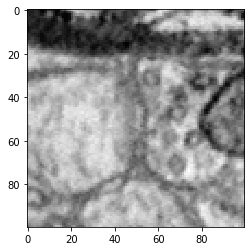

Prediction: 1 , Ground Truth: 1


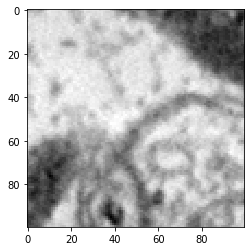

Prediction: 0 , Ground Truth: 0


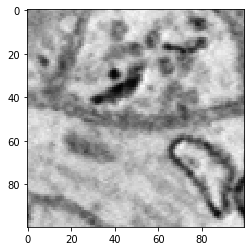

Prediction: 1 , Ground Truth: 1


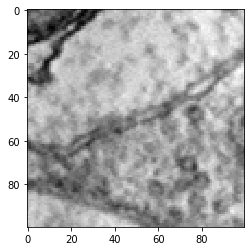

Prediction: 1 , Ground Truth: 1


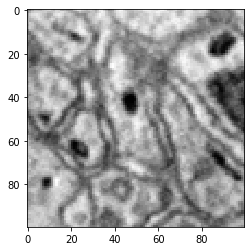

Prediction: 0 , Ground Truth: 0


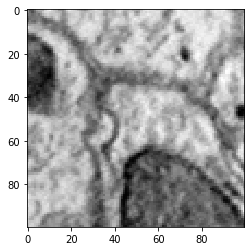

Prediction: 0 , Ground Truth: 0


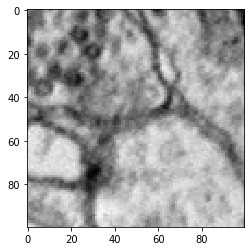

Prediction: 1 , Ground Truth: 1


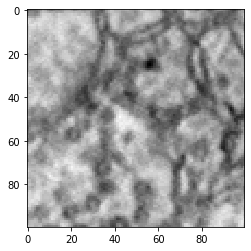

Prediction: 0 , Ground Truth: 1


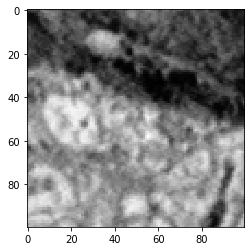

Prediction: 0 , Ground Truth: 0


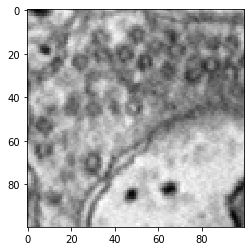

Prediction: 1 , Ground Truth: 1


In [20]:
for i in range(10):
    temp = random.randint(0,X_test.shape[0] - 1)
    plt.imshow(X_test[temp].reshape((100,100)), cmap = 'gray')
    plt.show()
    print("Prediction: " + str(y_pred[temp]) + ' , Ground Truth: ' + str(y_test[temp]))

In [21]:
print(np.unique(y_test, return_counts=True))
print(np.unique(y_pred, return_counts=True))

(array([0, 1]), array([ 94, 106]))
(array([0, 1]), array([ 90, 110]))
